## Random Forest
Random forest is a supervised algorithm that uses an ensemble learning method consisting of decision trees, the output of which is the consensus of the best answer to the problem. Decision trees arrive at an answer by asking a series of true/false questions about elements in a data set. The presence of a large number of trees also reduces the problem of overfitting, which occurs when a model incorporates too much “noise” in the training data and makes poor decisions as a result. Random Forest can be used for classification, thus can predict whether a user will be active or not. 

### 1. Imports

In [1]:
# imports
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
import seaborn as sns

from sklearn.compose import ColumnTransformer, make_column_selector as selector
from sklearn.impute import SimpleImputer
from sklearn.preprocessing import OrdinalEncoder
from sklearn.pipeline import Pipeline
from sklearn.ensemble import RandomForestClassifier
from sklearn.model_selection import train_test_split, RandomizedSearchCV, GridSearchCV
from sklearn.metrics import (
    classification_report, confusion_matrix, roc_auc_score, roc_curve,
    precision_recall_curve, f1_score, accuracy_score
)
from joblib import Memory
from scipy.stats import randint, uniform
import shap

/opt/anaconda3/envs/music-thesis/lib/python3.12/site-packages/tqdm/auto.py:21: TqdmWarning: IProgress not found. Please update jupyter and ipywidgets. See https://ipywidgets.readthedocs.io/en/stable/user_install.html
  from .autonotebook import tqdm as notebook_tqdm


### 2. Loading data

In [2]:
df = pd.read_csv("../data/user_level_data.csv")
print(f"Dataset shape: {df.shape}")
print(f"\nTarget variable distribution:\n{df['y_active'].value_counts()}")
print(f"Class balance: {df['y_active'].value_counts(normalize=True)}")

Dataset shape: (20011, 31)

Target variable distribution:
y_active
0    14230
1     5781
Name: count, dtype: int64
Class balance: y_active
0    0.711109
1    0.288891
Name: proportion, dtype: float64


### 3. Preprocessing

In [3]:
# Drop id column
id_columns = ["userId"]
target = "y_active"
columns_to_drop = [target] + [c for c in id_columns if c in df.columns]
print(f"\nDropping ID columns: {[c for c in id_columns if c in df.columns]}")
X_raw = df.drop(columns=columns_to_drop, errors="ignore")

# Set target variable
y = df["y_active"].astype(int)

# Identify numerical and categorical features
num_cols = selector(dtype_include=np.number)(X_raw)
cat_cols = [c for c in X_raw.columns if c not in num_cols]

print(f"\nNumeric features: {len(num_cols)}")
print(f"Categorical features: {len(cat_cols)}")

# Preprocessing pipelines
numeric_tf = Pipeline([
    ("imputer", SimpleImputer(strategy="median"))
])

categorical_tf = Pipeline([
    ("imputer", SimpleImputer(strategy="most_frequent")),
    ("encoder", OrdinalEncoder(handle_unknown="use_encoded_value", unknown_value=-1))
])

preprocess = ColumnTransformer([
    ("num", numeric_tf, num_cols),
    ("cat", categorical_tf, cat_cols)
])

# Train-test split
X_train, X_test, y_train, y_test = train_test_split(
    X_raw, y,
    test_size=0.3,
    random_state=42,
    stratify=y
)
print(f"\nTraining set size: {X_train.shape}")
print(f"Test set size:     {X_test.shape}")

# Model Pipeline with Caching
cache = Memory(location="cache_rf", verbose=0)
rf = RandomForestClassifier(
    n_jobs=-1,
    bootstrap=True,            # required for max_samples
    class_weight="balanced",   # helpful if imbalanced
    random_state=42
)
pipe = Pipeline([("prep", preprocess), ("rf", rf)], memory=cache)



Dropping ID columns: ['userId']

Numeric features: 28
Categorical features: 1

Training set size: (14007, 29)
Test set size:     (6004, 29)


### 4. Hyperparameter Tuning

In [4]:
# Grid Search for Hyperparameter Tuning
param_grid = {
    "rf__n_estimators": [100], 
    "rf__max_depth": [None], 
    "rf__min_samples_split": [10], 
    "rf__min_samples_leaf": [4], 
    "rf__max_features": [0.6], 
    "rf__max_samples": [0.8] 
}
"""

param_grid = {
    "rf__n_estimators": [100], # keeping it fixed for faster tuning 
    "rf__max_depth": [None, 10, 20], # None
    "rf__min_samples_split": [2, 5, 10], # 10
    "rf__min_samples_leaf": [1, 2, 4], # 4
    "rf__max_features": ["sqrt", 0.4, 0.6], # 0.6
    "rf__max_samples": [0.6, 0.7, 0.8] # 0.8
}
"""

search = GridSearchCV(
    estimator=pipe,
    param_grid=param_grid,
    cv=3,
    scoring="roc_auc",         
    n_jobs=-1,
    verbose=1,
    return_train_score=False
)

print("\nRunning GridSearchCV...")
search.fit(X_train, y_train)

print("\n" + "="*60)
print("BEST PARAMETERS FROM GRID SEARCH:")
print("="*60)
print("\nBest Parameters:", search.best_params_)
print("Best CV ROC-AUC:", f"{search.best_score_:.4f}")


Running GridSearchCV...
Fitting 3 folds for each of 1 candidates, totalling 3 fits

BEST PARAMETERS FROM GRID SEARCH:

Best Parameters: {'rf__max_depth': None, 'rf__max_features': 0.6, 'rf__max_samples': 0.8, 'rf__min_samples_leaf': 4, 'rf__min_samples_split': 10, 'rf__n_estimators': 100}
Best CV ROC-AUC: 0.9303


### 5. Fit model with best parameters

In [5]:
# Fit model with best parameters
best_model = search.best_estimator_
best_model.set_params(rf__n_estimators=500)
print("\nRefitting best model with n_estimators=500 for stability...")
best_model.fit(X_train, y_train)

# Predictions
y_pred = best_model.predict(X_test)
y_pred_proba = best_model.predict_proba(X_test)[:, 1]
print("\nModel predictions completed.")


Refitting best model with n_estimators=500 for stability...

Model predictions completed.


### 6. Evaluation


MODEL PERFORMANCE METRICS

Classification Report:

Accuracy: 0.8623
              precision    recall  f1-score   support

           0     0.9783    0.8245    0.8949      4269
           1     0.6887    0.9550    0.8003      1735

    accuracy                         0.8623      6004
   macro avg     0.8335    0.8898    0.8476      6004
weighted avg     0.8946    0.8623    0.8675      6004



Confusion Matrix:
[[3520  749]
 [  78 1657]]


ROC-AUC Score and Curve:

ROC-AUC Score: 0.9367
F1 Score (weighted): 0.8675


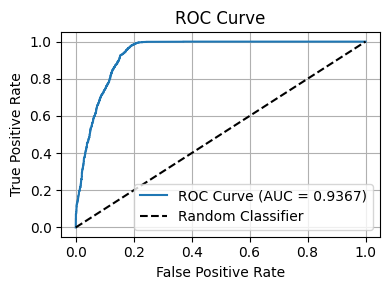



Precision-Recall Curve:


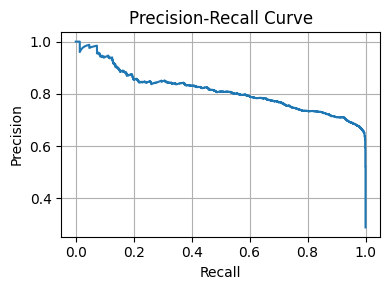



Feature importance (SHAP values):


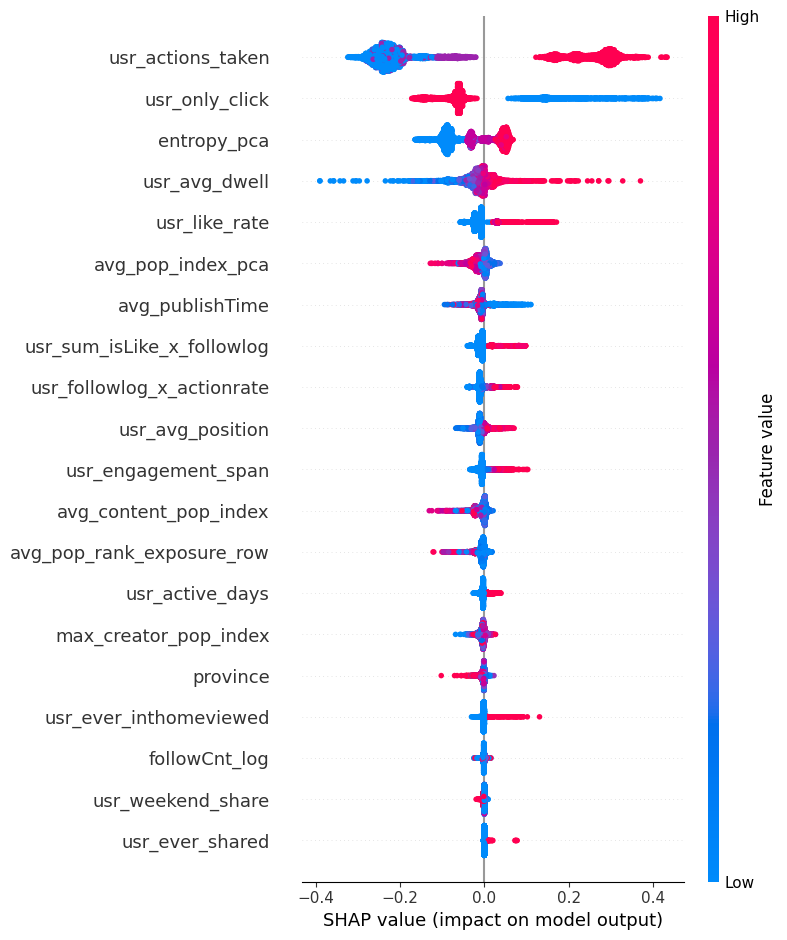

In [6]:
print("\n" + "="*60)
print("MODEL PERFORMANCE METRICS")
print("="*60)
print("\nClassification Report:")
# Classification report
accuracy = accuracy_score(y_test, y_pred)
print(f"\nAccuracy: {accuracy:.4f}")
print(classification_report(y_test, y_pred, digits=4))

print("\n" + "="*60)
print("\nConfusion Matrix:")
# Confusion matrix
print(confusion_matrix(y_test, y_pred))

print("\n" + "="*60)
print("\nROC-AUC Score and Curve:")
# ROC-AUC Score and Curve
try:
    roc_auc = roc_auc_score(y_test, y_pred_proba)
    print(f"\nROC-AUC Score: {roc_auc:.4f}")
except Exception:
    print("\nROC-AUC Score: Not available")

f1 = f1_score(y_test, y_pred, average="weighted")
print(f"F1 Score (weighted): {f1:.4f}")
fig1, ax1 = plt.subplots(figsize=(4, 3))
try:
    fpr, tpr, _ = roc_curve(y_test, y_pred_proba)
    ax1.plot(fpr, tpr, label=f'ROC Curve (AUC = {roc_auc:.4f})')
    ax1.plot([0, 1], [0, 1], 'k--', label='Random Classifier')
    ax1.set_xlabel('False Positive Rate')
    ax1.set_ylabel('True Positive Rate')
    ax1.set_title('ROC Curve')
    ax1.legend()
    ax1.grid(True)
except Exception:
    ax1.text(0.5, 0.5, 'ROC Curve not available', ha='center', va='center')
plt.tight_layout()
plt.show()
# Precision-Recall Curve
fig, axes = plt.subplots(figsize=(4, 3))
try:
    print("\n" + "="*60)
    print("\nPrecision-Recall Curve:")
    precision, recall, _ = precision_recall_curve(y_test, y_pred_proba)
    axes.plot(recall, precision)
    axes.set_xlabel('Recall')
    axes.set_ylabel('Precision')
    axes.set_title('Precision-Recall Curve')
    axes.grid(True)
except Exception:
    axes.text(0.5, 0.5, 'Precision-Recall Curve not available', ha='center', va='center')
plt.tight_layout()
plt.show()

print("\n" + "="*60)
print("\nFeature importance (SHAP values):")
# Feature importance (SHAP values)

prep = best_model.named_steps["prep"]
rf   = best_model.named_steps["rf"]

X_test_t = prep.transform(X_test)

explainer = shap.TreeExplainer(rf)
shap_values_all = explainer.shap_values(X_test_t)  
shap_values_pos = shap_values_all[:, :, 1]        
feature_names = list(num_cols) + list(cat_cols)

shap.summary_plot(
    shap_values_pos,
    features=X_test_t,
    feature_names=feature_names,
    plot_type="dot",
    max_display=20
)